In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pylab as pl, itertools as it
libPath = 'project1/scripts'
import sys
if not libPath in sys.path: sys.path.append(libPath)
from implementations import *
from proj1_helpers import *
from helpers import *



# 1. Choosing a model

Simple linear model:
$y = w_1x_1+\dots + w_nx_n$

In [2]:
feature_cols = [1, 3, 4, 8, 10, 11, 12, 13, 22]
# feature_cols = [0, 1, 2, 7, 10, 11, 13, 19]
N_VALID_FEATURES = len(feature_cols)

In [3]:
y, inputs_or, ids = load_csv_data("full_train_data.csv", False)
print(y.shape)
print(inputs_or.shape)
print(ids.shape)
y

(250000,)
(250000, 30)
(250000,)


array([ 1., -1., -1., ...,  1., -1., -1.])

In [4]:
y_TEST, inputs_TEST, ids_TEST = load_csv_data("full_train_data.csv", False)

In [7]:
inputs, inputs_m, inputs_std = standardize(inputs_or)
tx.shape

(250000, 30)

In [8]:
print("Mean: ", np.mean(inputs,0))
print("Std: ", np.std(inputs,0))

Mean:  [-1.44181997e-12  4.49388038e-15 -3.48051743e-15  7.19326732e-15
  5.54492262e-12 -7.06034603e-12 -1.25200608e-12  2.16639258e-14
  6.39519815e-15  2.86378610e-15 -7.00413105e-15  4.40404957e-15
 -5.06993495e-12 -5.96698879e-15  1.31851863e-16  6.98427982e-17
  2.58050010e-14 -1.06905595e-16 -1.84545268e-16  8.24480671e-15
  1.40987222e-16 -8.99948738e-15 -6.01698247e-16  1.73750464e-12
  4.22403081e-15 -9.73910979e-15  1.21723732e-11  9.18768264e-15
  4.19652004e-15 -8.78904061e-16]
Std:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [9]:
N_FEATURES = inputs_or.shape[1]
N_DATA = len(inputs_or)

In [10]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    y_te = y[k_indices[k]]    
    x_te = x[k_indices[k]]
    
    y_tr = np.delete(y, k_indices[k], axis=0)
    x_tr = np.delete(x, k_indices[k], axis=0)
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    Phi_tr = build_poly(x_tr, degree)
    Phi_te = build_poly(x_te, degree)
    # form data with polynomial degree: TODO
    # ***************************************************
    w, loss_tr = ridge_regression(y_tr, Phi_tr, lambda_)
    # ridge regression: TODO
    # ***************************************************
    loss_te = compute_mse(y_te, Phi_te, w)
    loss_tr = compute_mse(y_tr, Phi_tr, w)
    # calculate the loss for train and test data: TODO
    # ***************************************************
    return loss_tr, loss_te, w

In [11]:
x = inputs[:,feature_cols]
degree = 1
k_fold = 4
lambdas = np.logspace(-4, 0, 30)
rmse_tr = []
rmse_te = []

k_indices = build_k_indices(y, k_fold, 1)
for l in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation(y, x, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.mean(np.sqrt(2*rmse_tr_tmp)))
    rmse_te.append(np.mean(np.sqrt(2*rmse_te_tmp)))


#tx = build_poly(x, degree)
#y_test = tx @ w
#y_test[y_test >= 0] = 1
#y_test[y_test < 0] = -1


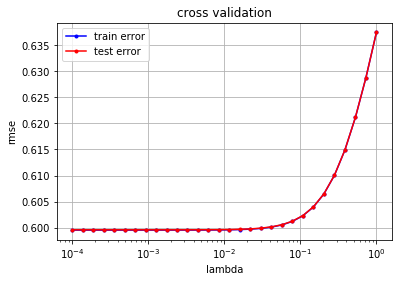

In [12]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

In [13]:
np.argmin(rmse_te)

5

In [23]:
x_TEST = inputs[:,feature_cols]
k_indices = build_k_indices(y_TEST, 2, 1)
y_test = y_TEST[k_indices[0]]    
x_test = x_TEST[k_indices[0]]

y_train = np.delete(y_TEST, k_indices[0], axis=0)
x_train = np.delete(x_TEST, k_indices[0], axis=0)
tx_tr = build_poly(x_train, degree)
tx_te = build_poly(x_test, degree)


weights, mse = ridge_regression(y_train, tx_tr, lambdas[np.argmin(rmse_te)])


In [24]:
weights

array([-0.31374113, -0.24337028, -0.00175733,  0.09617337, -0.02603482,
       -0.0034392 ,  0.1322886 ,  0.07373047,  0.17172217, -0.00616831])

In [25]:
y_pred = predict_labels(weights, tx_te)
ones_aux = np.ones(len(y_pred))
correct = np.sum(ones_aux[np.equal(y_test, y_pred)])
incorrect = len(y_pred)-correct
perc = correct / len(y_pred) * 100
print("Total correct:", correct, "\nTotal incorrect:", incorrect, "\nCorrect percentage:", perc, "%")

print("-----------------------------")

rmse_train = np.sqrt(2*compute_mse(y_train, tx_tr, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_te, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)


Total correct: 90500.0 
Total incorrect: 34500.0 
Correct percentage: 72.39999999999999 %
-----------------------------
Train RMSE: 0.8474840547657798 , Test RMSE: 0.8482789260665095


4-th order linear model:
$y = w_0+w_1x_1+\dots+ w_nx_1^n +\dots$

In [26]:
x = inputs[:,feature_cols]
degree = 4
k_fold = 4
lambdas = np.logspace(-4, 0, 30)
rmse_tr = []
rmse_te = []

k_indices = build_k_indices(y, k_fold, 1)
for l in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation(y, x, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.mean(np.sqrt(2*rmse_tr_tmp)))
    rmse_te.append(np.mean(np.sqrt(2*rmse_te_tmp)))


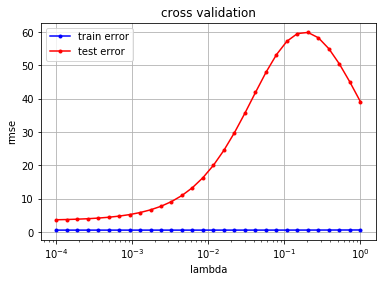

In [27]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

In [28]:
np.argmin(rmse_te)

0

In [31]:
x_TEST = inputs[:,feature_cols]
k_indices = build_k_indices(y, 2, 18)
y_test = y_TEST[k_indices[0]]    
x_test = x_TEST[k_indices[0]]

y_train = np.delete(y_TEST, k_indices[0], axis=0)
x_train = np.delete(x_TEST, k_indices[0], axis=0)
tx_tr = build_poly(x_train, degree)
tx_te = build_poly(x_test, degree)

print(tx_tr.shape)
weights, mse = ridge_regression(y_train, tx_tr, lambdas[np.argmin(rmse_te)])


(125000, 37)


In [32]:
y_pred = predict_labels(weights, tx_te)
ones_aux = np.ones(len(y_pred))
correct = np.sum(ones_aux[np.equal(y_test, y_pred)])
incorrect = len(y_pred)-correct
perc = correct / len(y_pred) * 100
print("Total correct:", correct, "\nTotal incorrect:", incorrect, "\nCorrect percentage:", perc, "%")

print("-----------------------------")

rmse_train = np.sqrt(2*compute_mse(y_train, tx_tr, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_te, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)



Total correct: 93669.0 
Total incorrect: 31331.0 
Correct percentage: 74.93520000000001 %
-----------------------------
Train RMSE: 0.8163342841249744 , Test RMSE: 0.8170878223335576


A more complicated model:
Order 2:
$y=w_0 + w_1x_1 + w_2x_2 +w_3x_1^2 +w_4x_2^2+w_5x_1x_2+\dots$

In [46]:
def cross_validation_poly(y, tx, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    y_te = y[k_indices[k]]    
    tx_te = tx[k_indices[k]]
    
    y_tr = np.delete(y, k_indices[k], axis=0)
    tx_tr = np.delete(tx, k_indices[k], axis=0)
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    w, loss_tr = ridge_regression(y_tr, tx_tr, lambda_)
    # ridge regression: TODO
    # ***************************************************
    loss_te = compute_mse(y_te, tx_te, w)
    loss_tr = compute_mse(y_tr, tx_tr, w)
    # calculate the loss for train and test data: TODO
    # ***************************************************
    return loss_tr, loss_te, w

def build_poly_plus(x, degree):
    poly = np.ones((len(x), 1))

    for deg in range(1, degree+1):
        if deg == 1:
            poly = np.c_[poly, x]
        else:
            for i in it.combinations_with_replacement(range(x.shape[1]),degree):
                poly = np.c_[poly, np.prod(x[:,i],1)]
    return poly

In [43]:
import itertools

# TODO: Optimize. Very slow!
def build_mult_comb(tx, deg, cols=[]):
    """
    Returns all multiplicative combinations of the specified columns for degree deg.
    For len(col) = D', there are (D' choose deg) combinations of columns that get
    returned as a matrix.
    If cols is not given, it returns the combinations of all columns of tx.
    """
    N = tx.shape[0]
    if (cols == []):
        comb_iter = itertools.combinations_with_replacement(range(tx.shape[1]), deg)
    else:
        comb_iter = itertools.combinations_with_replacement(cols, deg)
    mult = []
    for comb in comb_iter:
        mult_col = np.ones(N)
        for idx in comb:
            tx_col = tx[:,idx]
            mult_col = np.multiply(mult_col, tx_col)
        mult.append(mult_col.tolist())
    return np.array(mult).T

def build_poly_adv(tx, degree, cols=[]):
    """
    Builds full polynomial basis function for input data matrix tx, for j=0 up to j=degree,
    where the result will be a matrix of form:
    [1, tx, comb_mult(tx, 2), ..., comb_mult(tx, j)]
    comb_mult(tx, 2) denotes all multiplicative combinations of the selected columns of tx.
    If cols is not given, it returns the combinations of all columns of tx.
    """
    poly = np.ones((tx.shape[0], 1))

    for j in range(1, degree+1):
        mult = build_mult_comb(tx, j, cols)
        poly = np.column_stack((poly, mult))

    return poly

In [77]:
x = inputs
degree = 2
tx = build_poly_plus(x[:,feature_cols], degree)

In [78]:
k_fold = 4
lambdas = np.logspace(-5, 0, 20)

rmse_tr = []
rmse_te = []

k_indices = build_k_indices(y, k_fold, 1)
for l in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation_poly(y, tx, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.sqrt(2*np.mean(rmse_tr_tmp)))
    rmse_te.append(np.sqrt(2*np.mean(rmse_te_tmp)))
    print("lambda={la:.9f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               la=l, tr=rmse_tr[-1], te=rmse_te[-1]))


lambda=0.000010000, Training RMSE=0.814, Testing RMSE=0.839
lambda=0.000018330, Training RMSE=0.814, Testing RMSE=0.839
lambda=0.000033598, Training RMSE=0.814, Testing RMSE=0.839
lambda=0.000061585, Training RMSE=0.814, Testing RMSE=0.839
lambda=0.000112884, Training RMSE=0.814, Testing RMSE=0.839
lambda=0.000206914, Training RMSE=0.814, Testing RMSE=0.839
lambda=0.000379269, Training RMSE=0.814, Testing RMSE=0.839
lambda=0.000695193, Training RMSE=0.814, Testing RMSE=0.838
lambda=0.001274275, Training RMSE=0.814, Testing RMSE=0.837
lambda=0.002335721, Training RMSE=0.814, Testing RMSE=0.836
lambda=0.004281332, Training RMSE=0.814, Testing RMSE=0.834
lambda=0.007847600, Training RMSE=0.814, Testing RMSE=0.830
lambda=0.014384499, Training RMSE=0.815, Testing RMSE=0.826
lambda=0.026366509, Training RMSE=0.817, Testing RMSE=0.823
lambda=0.048329302, Training RMSE=0.820, Testing RMSE=0.822
lambda=0.088586679, Training RMSE=0.824, Testing RMSE=0.825
lambda=0.162377674, Training RMSE=0.831,

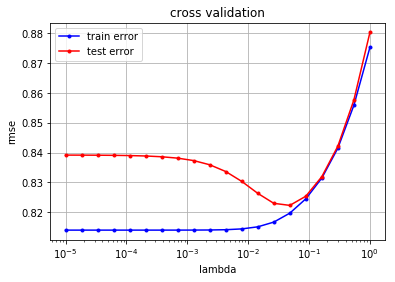

In [79]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

In [80]:
np.argmin(rmse_te)

14

In [81]:
tx_TEST = build_poly_plus(inputs[:,feature_cols], degree)

k_indices = build_k_indices(y_TEST, 2, 17)
y_test = y_TEST[k_indices[0]]    
tx_test = tx_TEST[k_indices[0]]

y_train = np.delete(y_TEST, k_indices[0], axis=0)
tx_train = np.delete(tx_TEST, k_indices[0], axis=0)

print(tx_train.shape)
weights, mse = ridge_regression(y_train, tx_train, lambdas[np.argmin(rmse_te)])


(125000, 55)


In [82]:
y_pred = predict_labels(weights, tx_test)
ones_aux = np.ones(len(y_pred))
correct = np.sum(ones_aux[np.equal(y_test, y_pred)])
incorrect = len(y_pred)-correct
perc = correct / len(y_pred) * 100
print("Total correct:", correct, "\nTotal incorrect:", incorrect, "\nCorrect percentage:", perc, "%")

print("-----------------------------")

rmse_train = np.sqrt(2*compute_mse(y_train, tx_train, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_test, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)



Total correct: 93850.0 
Total incorrect: 31150.0 
Correct percentage: 75.08 %
-----------------------------
Train RMSE: 0.8187515441933548 , Test RMSE: 0.8264246781366931


# Test set

In [54]:
def replace_nan_by_mean(tx, nan_value):
    """Replaces values with a specified nan_value by the column mean."""
    tx[tx == nan_value] = np.nan
    col_mean = np.nanmean(tx, axis=0)
    return np.where(np.isnan(tx), col_mean, tx)

In [57]:
y_test, inputs_test, ids_test = load_csv_data('test.csv', sub_sample=False)

In [58]:
print('Proportion of missing data in each feature: \n', np.count_nonzero(inputs_test== -999,0)/len(y_test) )

Proportion of missing data in each feature: 
 [0.15220383 0.         0.         0.         0.70885087 0.70885087
 0.70885087 0.         0.         0.         0.         0.
 0.70885087 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.4002865
 0.4002865  0.4002865  0.70885087 0.70885087 0.70885087 0.        ]


In [59]:
np.mean(inputs_test[:,feature_cols],0)

array([ 4.92583872e+01,  5.78290937e+01, -7.07441800e+02,  1.89926203e+01,
        1.43928858e+00, -1.26825167e-01, -7.08008508e+02,  3.86940752e+01,
        9.80251233e-01])

In [60]:
input_data_na = inputs_test.copy()
for col in feature_cols: 
    input_data_na = input_data_na[~(input_data_na[:,col]==-999)]
mean = np.mean(input_data_na,0)
for i in feature_cols:
    if any(inputs_test[:,i] == -999):
        np.place(inputs_test[:,i], inputs_test[:,i] == -999, mean[i])

In [64]:
inputs_test_s ,_,_= standardize(inputs_test)

In [65]:
# tx_test = build_poly(inputs_test[:,feature_cols], degree)
tx_test = build_poly_plus(inputs_test_s[:,feature_cols], degree)
tx_test.shape


(568238, 55)

In [66]:
y_pred = predict_labels(weights, tx_test)
y_pred.shape

(568238,)

In [67]:
create_csv_submission(ids_test, y_pred, 'prediction.csv')


In [ ]:
ids_